# Application: The Capital Asset Pricing Model (CAPM)

CAPM remains one of the workhorse statistical models in finance.  It is so common that sites like Yahoo!Finance report the measures we will estimate statistically.  

I use CAPM for a reason: absent experimental data, it is the only application of the bivariate linear model that I believe has validity in the real world.

The upshot of the CAPM says that we can directly interpret the intercept and slope coefficients as real-world measures relating the excess (or risk-adjusted) returns of a particular stock to those of a basket of stocks, such as a specific market.

## CAPM as a Bivariate Linear Model

Let $r_i$ denote the rate of return to asset $i$, $r_f$ denote the known rate of return on a risk-free asset (for example, short-term US government debt), and $r_m$ denote the rate of return to a portfolio (or a market) that includes $i$.  

The following equation can be derived:

$E(r_i)-r_f = \alpha + \beta \cdot (E(r_m)-r_f)$

Here, $E(\cdot)$ denotes an expected value (because this is a forward-looking prediction).  In CAPM, $\beta$ captures the sensitivity of an asset’s returns to the returns to a portfolio or to the market on which an asset trades.  In other words, it non-diversifiable risk.  In addition, $\alpha$ measures an asset $i$’s excess (or abnormal) returns.

Phrases you may have heard: 

1. The stock's beta is high
2. The hedge fund is chasing alpha

Formally, we can express our conjecture as a joint hypothesis:

$H_0: \alpha = 0, \beta=1$

$H_1: \text{ not }H_0$

In [1]:
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas.io.data as web
import Quandl
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot
import patsy
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Grab 10 years of Apple and NASDAQ data using Quandl.  You can also you pandas.io.data to grab from sites like Yahoo!Finance.
# Apple trades internationally on the NASDAQ OMX.  

aapl_all = Quandl.get("YAHOO/AAPL", trim_start="2005-1-1")
nasdaq_all = Quandl.get("NASDAQOMX/COMP", trim_start="2005-1-1")
aapl = aapl_all['Adjusted Close']
nasdaq = nasdaq_all['Index Value']

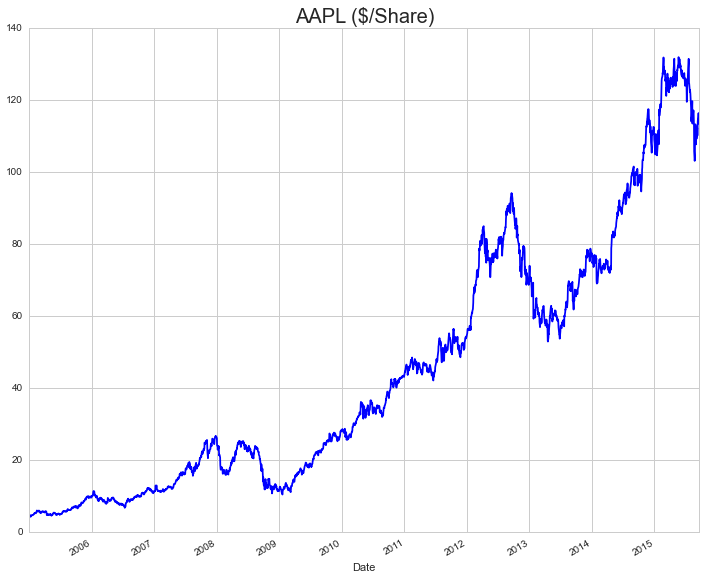

In [3]:
plt.figure(figsize = (12,10))
#plt.plot(aapl)
aapl.plot(color='blue')
plt.title('AAPL ($/Share)', fontsize=20)

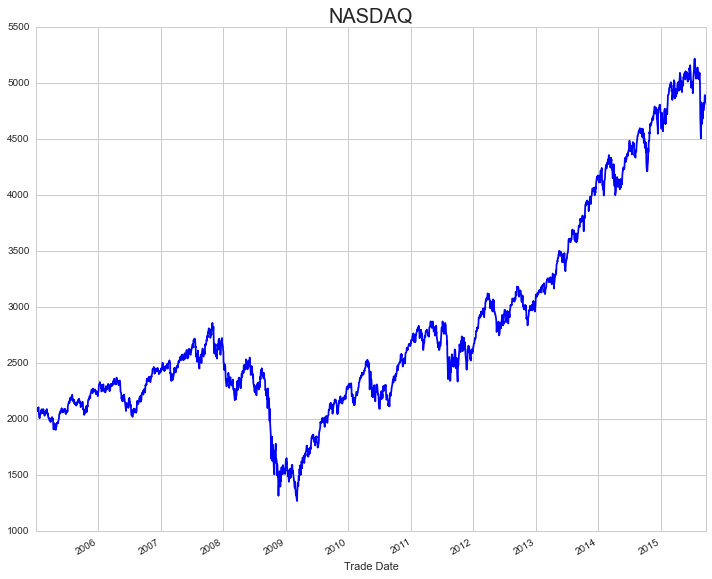

In [4]:
plt.figure(figsize = (12,10))
#plt.plot(nasdaq)
nasdaq.plot(color='blue')
plt.title('NASDAQ', fontsize=20)

In [5]:
# For our purposes, let's limit to the last five or so years.

aapl_all = Quandl.get("YAHOO/AAPL", trim_start="2010-1-1", 
                      trim_end="2015-9-18")
nasdaq_all = Quandl.get("NASDAQOMX/COMP", trim_start="2010-1-1", 
                        trim_end="2015-9-18")
aapl = aapl_all['Adjusted Close']
nasdaq = nasdaq_all['Index Value']

In [6]:
# Calculate log returns, which is the standard finance measure for daily returns in finance.

aapl_returns = np.log(aapl / aapl.shift(1))
nasdaq_returns = np.log(nasdaq / nasdaq.shift(1))
aapl_returns = aapl_returns.dropna()
nasdaq_returns = nasdaq_returns.dropna()

In [7]:
print aapl_returns.mean(), aapl_returns.std()

0.000959186621162 0.0168639800522


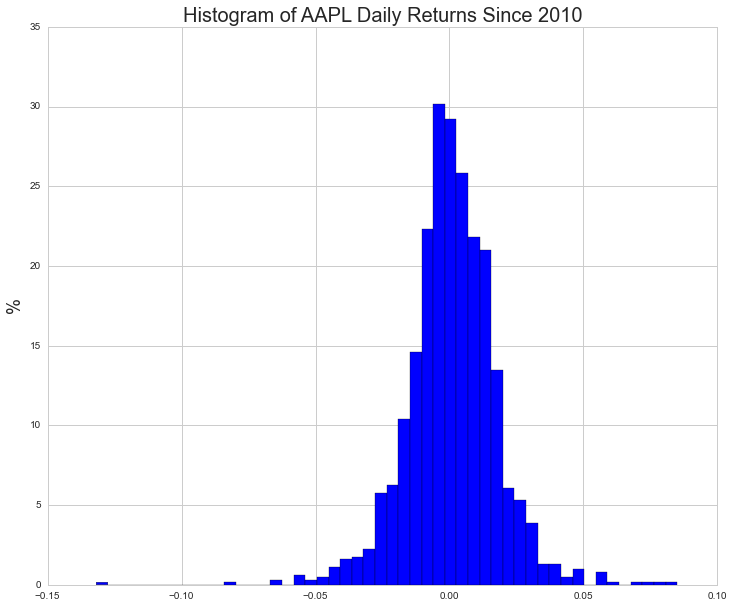

In [8]:
plt.figure(figsize= (12,10))
plt.hist(aapl_returns, bins=50, normed=True, color='blue')
plt.title('Histogram of AAPL Daily Returns Since 2010', fontsize=20)
plt.ylabel('%', fontsize=18)

In [9]:
print nasdaq_returns.mean(), nasdaq_returns.std()

0.000513367777564 0.0111897863269


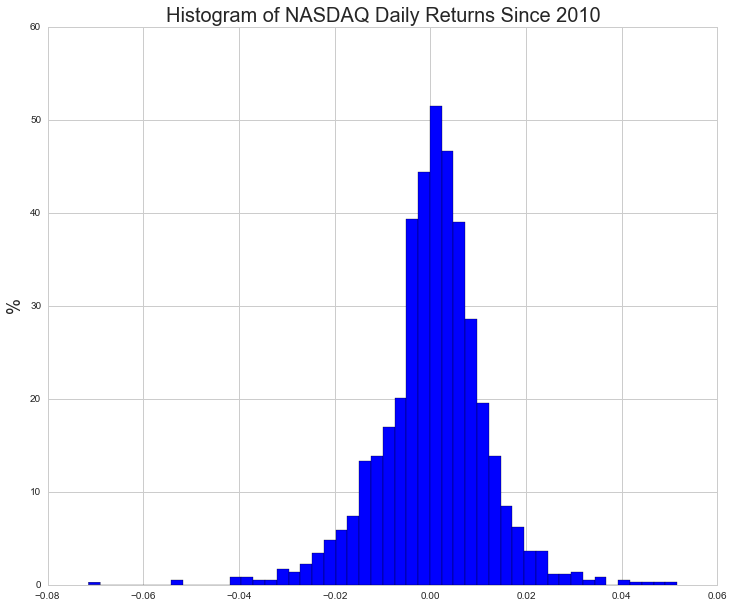

In [10]:
plt.figure(figsize= (12,10))
plt.hist(nasdaq_returns, bins=50, normed=True, color='blue')
plt.title('Histogram of NASDAQ Daily Returns Since 2010', fontsize=20)
plt.ylabel('%', fontsize=18)

In [11]:
# Create dataframes for merge and regression.

aapl_returns = pd.DataFrame(aapl_returns)
nasdaq_returns = pd.DataFrame(nasdaq_returns)

In [12]:
# Confirm dataframes

aapl_returns.info()
nasdaq_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1437 entries, 2010-01-05 to 2015-09-18
Data columns (total 1 columns):
Adjusted Close    1437 non-null float64
dtypes: float64(1)
memory usage: 22.5 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1437 entries, 2010-01-05 to 2015-09-18
Data columns (total 1 columns):
Index Value    1437 non-null float64
dtypes: float64(1)
memory usage: 22.5 KB


(-0.1, 0.1)

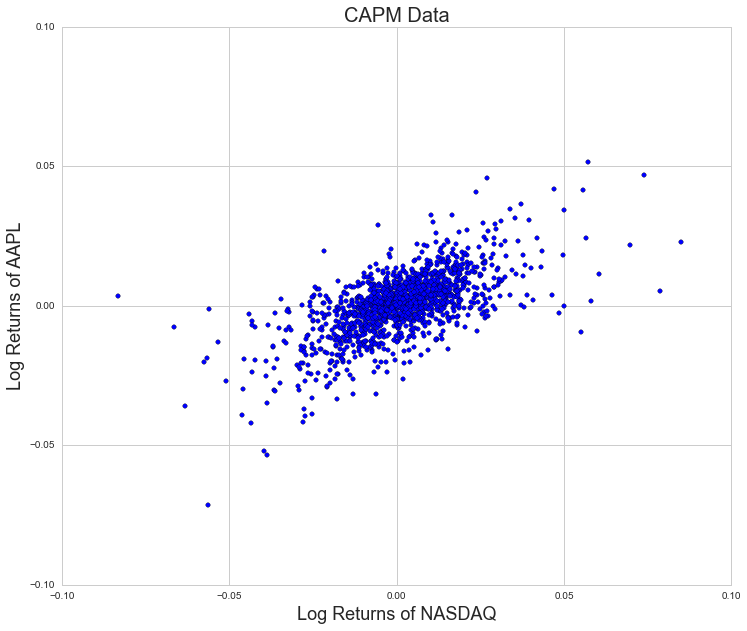

In [13]:
plt.figure(figsize = (12,10))
plt.scatter(aapl_returns, nasdaq_returns)
plt.title('CAPM Data', fontsize = 20)
plt.xlabel('Log Returns of NASDAQ', fontsize = 18)
plt.ylabel('Log Returns of AAPL', fontsize = 18)
plt.xlim([-0.1, 0.1])
plt.ylim([-0.1, 0.1])

In [14]:
# Merge and rename.

data = pd.merge(nasdaq_returns, aapl_returns, left_index=True, right_index=True)
data.rename(columns={'Index Value':'nasdaq', 'Adjusted Close':'aapl'}, inplace=True)

In [15]:
# Confirm summary stats

print data.mean()
print data.std()

nasdaq    0.000513
aapl      0.000959
dtype: float64
nasdaq    0.011190
aapl      0.016864
dtype: float64


In [16]:
# Use StatsModels Formula, which emulates R formula style.
# Run CAPM and review results.

mod = smf.ols(formula='aapl ~ nasdaq', data = data).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                   aapl   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     955.2
Date:                Tue, 22 Sep 2015   Prob (F-statistic):          3.49e-161
Time:                        09:29:56   Log-Likelihood:                 4194.7
No. Observations:                1437   AIC:                            -8385.
Df Residuals:                    1435   BIC:                            -8375.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0005      0.000      1.362      0.1

(-0.1, 0.1)

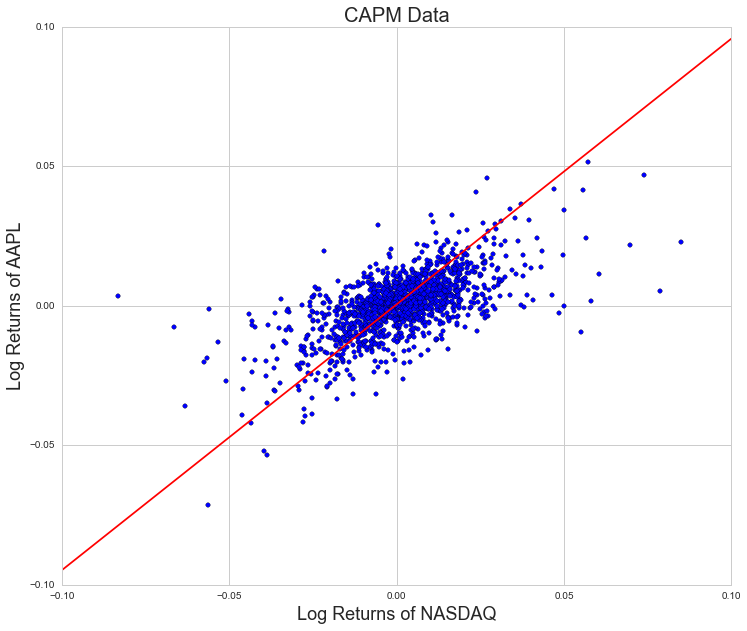

In [17]:
# This a convoluted

figure, ax = plt.subplots(figsize=(12,10))
ax.scatter(aapl_returns, nasdaq_returns)
mod = smf.ols(formula='aapl ~ nasdaq', data = data).fit()
abline_plot(model_results=mod, ax=ax, color='red')

ax.set_title('CAPM Data', fontsize = 20)
ax.set_ylabel('Log Returns of AAPL', fontsize = 18)
ax.set_xlabel('Log Returns of NASDAQ', fontsize = 18)
ax.set_xlim([-0.1, 0.1])
ax.set_ylim([-0.1, 0.1])

## Hypothesis Test with CAPM

Formally, we can express our conjecture as a joint hypothesis:

$H_0: \alpha = 0, \beta=1$

$H_1: \text{ not }H_0$

In [18]:
print mod.f_test("nasdaq = 1")

<F test: F=array([[ 2.35303401]]), p=0.125259865428, df_denom=1435, df_num=1>


In [19]:
print mod.f_test("Intercept = 0")

<F test: F=array([[ 1.85466091]]), p=0.173456023627, df_denom=1435, df_num=1>


In [20]:
print mod.f_test("nasdaq = 1, Intercept = 0")

<F test: F=array([[ 2.01230306]]), p=0.134057499231, df_denom=1435, df_num=2>


# My $R^2$ Is Bigger

Consider two data generating processes (DGPs), one with a smaller variance in the "system" as a whole.  These DGPs are identical, except for the variance in $\epsilon$, which in this example is simply exogenous noise.  

In [21]:
# Fix the random number generator.
np.random.seed(1066) 

# Generator normal error and feature.  Let e2 have a larger variance than e1.
e1 = np.random.normal(0, 1, 1000)  
e2 = np.random.normal(0, 4, 1000)
x = np.random.normal(0, 1, 1000) 

# DGPs for y1 and y2
y1 = 1 + 2 * x + e1  
y2 = 1 + 2 * x + e2  

# What is the correlation between y1 and y2?
np.corrcoef(y1, y2)[0, 1]

0.38460755003903313

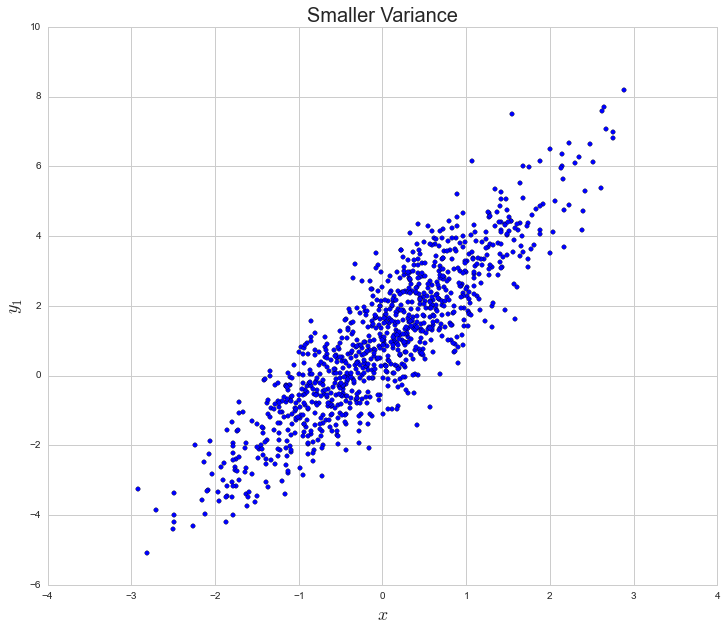

In [22]:
plt.figure(figsize = (12,10))
plt.scatter(x, y1)
plt.title('Smaller Variance', fontsize = 20)
plt.xlabel(r'$x$', fontsize = 18)
plt.ylabel(r'$y_1$', fontsize = 18)

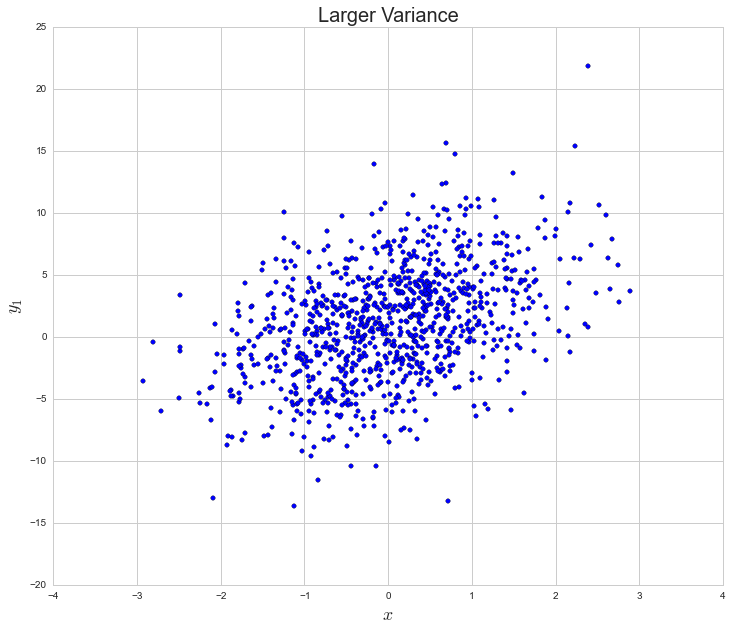

In [23]:
plt.figure(figsize = (12,10))
plt.scatter(x, y2)
plt.title('Larger Variance', fontsize = 20)
plt.xlabel(r'$x$', fontsize = 18)
plt.ylabel(r'$y_1$', fontsize = 18)

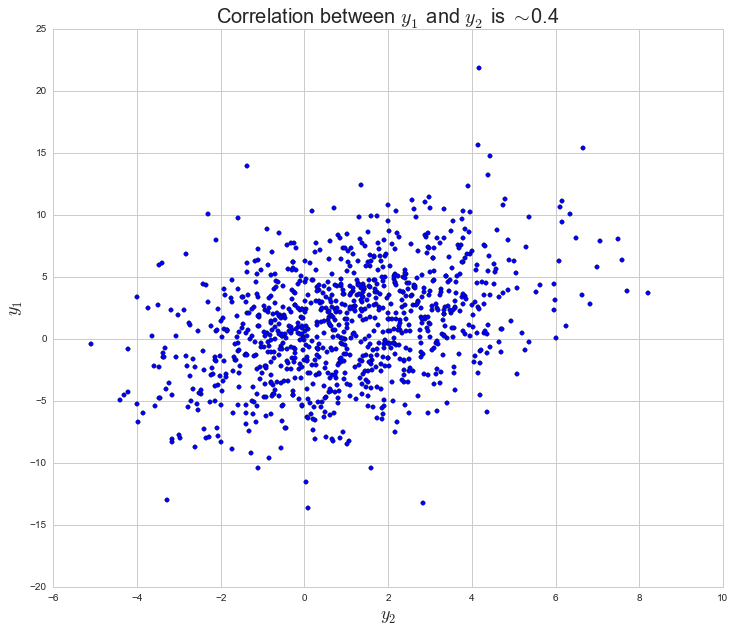

In [24]:
plt.figure(figsize = (12,10))
plt.scatter(y1, y2)
plt.title(r'Correlation between $y_1$ and $y_2$ is $\sim$0.4', fontsize = 20)
plt.xlabel(r'$y_2$', fontsize = 18)
plt.ylabel(r'$y_1$', fontsize = 18)

In [25]:
x = pd.DataFrame(x)
y1 = pd.DataFrame(y1)
y2 = pd.DataFrame(y2)

data1 = pd.merge(y1, x, left_index=True, right_index=True)
data2 = pd.merge(y2, x, left_index=True, right_index=True)

mod1 = smf.ols(formula='y1 ~ x', data=data1).fit()
mod2 = smf.ols(formula='y2 ~ x', data=data2).fit()
print(mod1.summary())
print(mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                     y1   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     3754.
Date:                Tue, 22 Sep 2015   Prob (F-statistic):               0.00
Time:                        09:29:59   Log-Likelihood:                -1411.4
No. Observations:                1000   AIC:                             2827.
Df Residuals:                     998   BIC:                             2837.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.9920      0.031     31.576      0.0

The regression model from the DGP with the greater exogenous variance yields a lower $R^2$ than the regression model from the DGP with the lesser exogenous variance.  But the DGPs are identical except for the exogenous noise.  While I can technically say "this $R^2$ is large," the statement in isolation must be put into the proper context: large relative to what?  